# Lecture 8. Visualizing what convnets learn

- Deep learning model은 모형을 해석하기 어렵다는 단점이 있어 흔히 'black box'모형이라고 불리우지만 CNN 모형은 hidden layer의 output("intermetdiate activation")을 시각화 함으로써 모형 해석력을 높일 수 있음

1. convolution layer의 output을 시각화
    - Convolutional layer가 입력 이미지를 연속적으로 변환해 가는 과정을 이해함으로써 각 filter의 의미를 이해 
2. 클래스 활성화에 대한 히트맵을 이미지에 시각화
    - 이미지의 어느 부분이 주어진 클래스에 속하는데 기여했는지 이해 

## 8.1 Visualizing intermediate activations
- 이전에 개/고양이 구분을 위해 학습해 두었던 모형을 loading하여 중간 층의 활성화를 시각화 하겠음

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

- Training에 사용되지 않은 input image를 사용하여 시각화 하기 위해 test set의 이미지 하나를 선택하고 input shape에 맞도록 4-D array로 형태 수정 

In [4]:
img_path = './data/cats_and_dogs_small/test/cats/cat.1700.jpg'

In [5]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

In [6]:
img_tensor.shape

(150, 150, 3)

In [7]:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
img_tensor.shape

(1, 150, 150, 3)

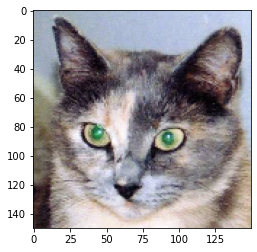

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

#### Reconstruct the model for intermediate layers
- 이미 학습된 keras model의 중간 layer들을 쪼개서 각 layer에서의 output을 출력해주는 새로운 모형을 이어붙여 만드는 과정
- Keras의 `models.Model` class를 사용 (multi-output model)
    - `inputs`: 학습된 model의 input (이미지)
    - `outputs`: fully connected layer를 제외한 각 layer의 output (여러 개의 output)

In [9]:
model.layers 

- 현재 load 된 model은 위와 같은 layer로 구성되어 있음
- 이 중 가장 위의 8개 layer를 골라서 output들을 구성

In [10]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [11]:
layer_outputs

[<tf.Tensor 'conv2d_1/Relu:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_2/Relu:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_3/Relu:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_4/Relu:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 7, 7, 128) dtype=float32>]

In [12]:
model.input

<tf.Tensor 'conv2d_1_input:0' shape=(None, 150, 150, 3) dtype=float32>

- `models.Model()`에서 input과 output을 지정하여 새로운 모형 `activation_model`을 구성
- output은 `layer_outputs`에 있는 8개의 output을 포함 

In [13]:
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

    
#### Visualize the 1st layer activations

In [14]:
len(activations)

8

In [15]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


- 첫번째 layer의 output: 148x148 feature map with 32 channels
- 이 중 0 번째 feature map을 시각화

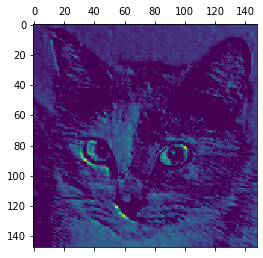

In [16]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()

- 첫번째 layer의 0번째  activations

#### Visualize all the channels of each layer

In [17]:
import keras

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)


In [18]:
layer_names

['conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4']

<ipython-input-19-4ba1f85a1ca5>:16: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


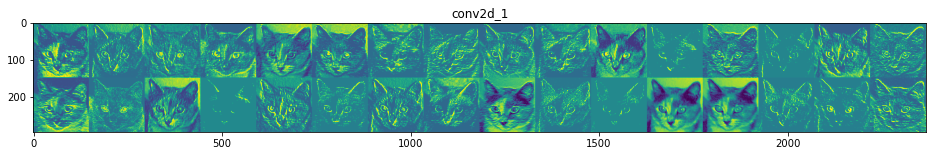

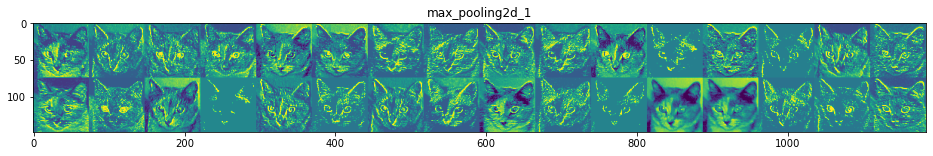

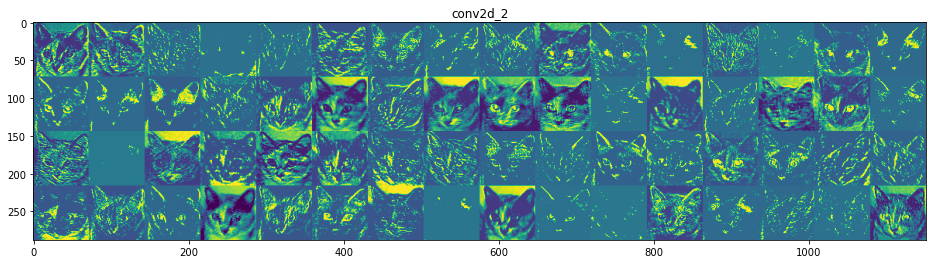

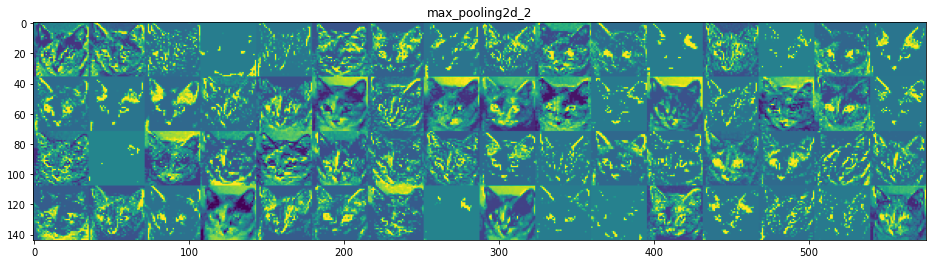

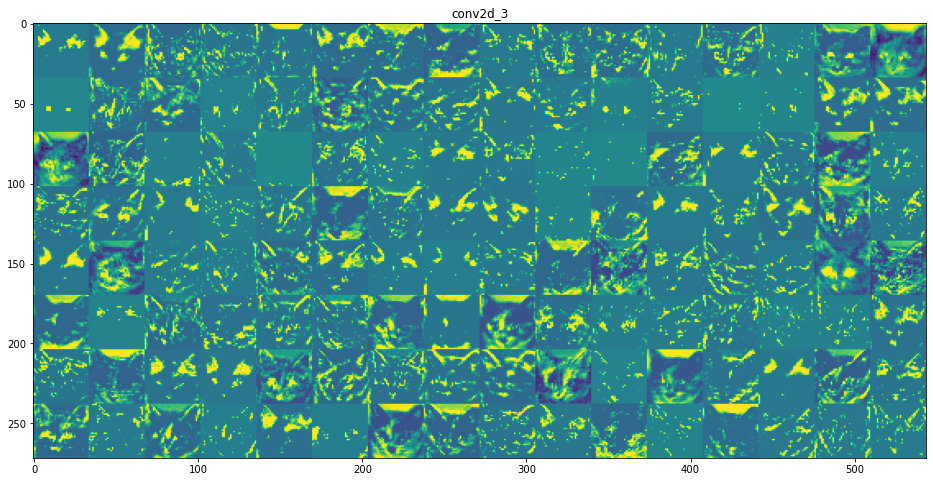

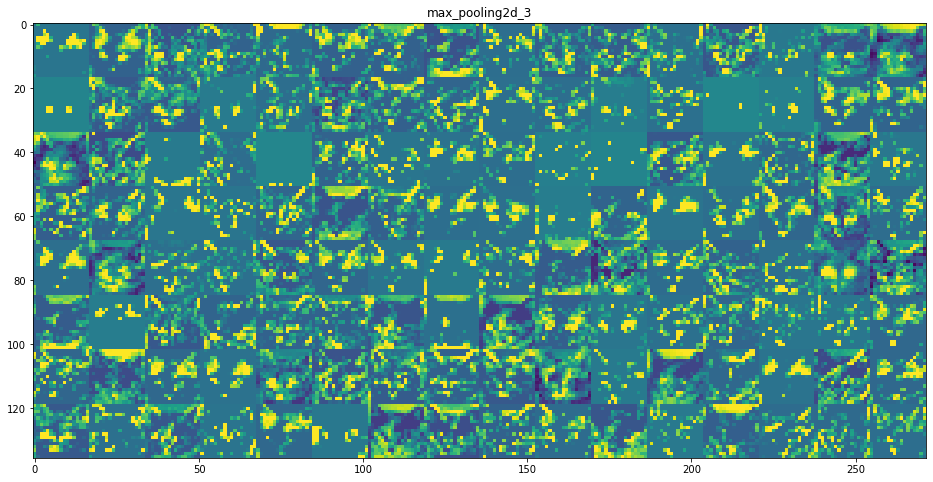

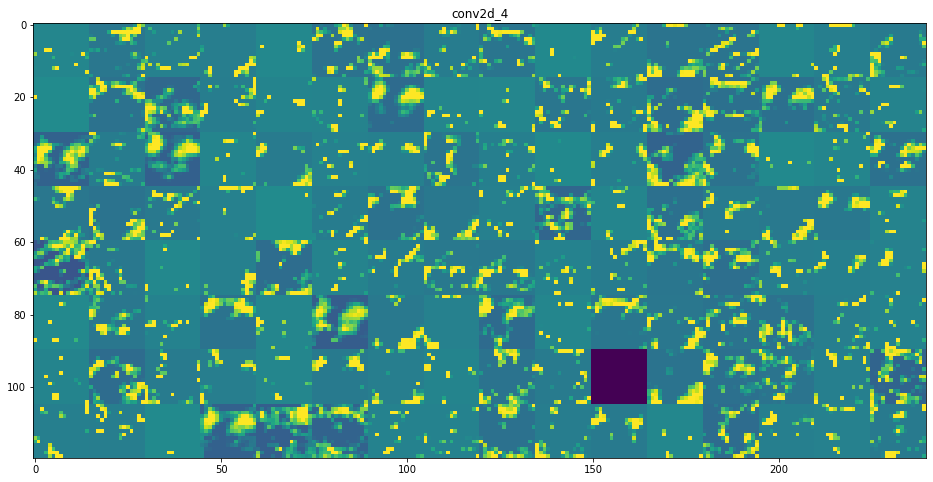

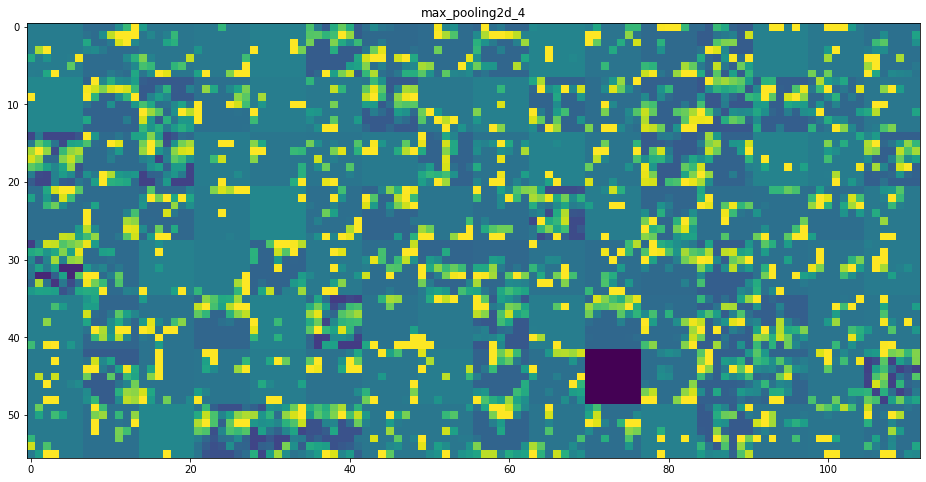

In [19]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] # the number of features in the feature map
    size = layer_activation.shape[1] # The feature map has shape (1, size, size, n_features)

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size)) # tile the activation channels in this matrix

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :, 
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

- 1st layer: 다양한 edge detector들의 모임. 고양이의 형체가 나타남 
- 깊은 layer로 갈 수록 activation이 추상화되어 시각적으로 해석하기 어렵지만 이미지의 class에 대한 정보를 더 포함하게 됨
    -  예) "cat ear" or "cat eye"
- 깉은 layer로 갈수록 activation이 비어 있는 곳이 발생 
    - 모든 filter가 activate되지 않음
    - 해당 filter가 표현하는 패턴이 input image에서 나타나지 않는 것을 의미 


## 8.2. Visualizing heatmaps of class activation: Class Activation Map (Grad-CAM)

- 이미지의 어느 부분이 최종 분류 결정에 기여하는지 확인 
- 물체의 위치를 파악하는데 사용 가능
- 개요
    - 하나의 입력 이미지를 넣었을 때 하나의 convolution layer(예를 들면, 모델을 구성하는 마지막 convolution layer)에서 출력되는 feature map들을 계산해냄
    - 분류된 클래스의 gradient를 계산하고 이를 가중치로 하여 feature map들을 평균을 취함
    - 해당 클래스에서 각 채널이 가지는 중요도에 따라 입력 이미지가 각 채널을 얼마나 강하게 활성화 시키는지 찾아내어 시각화
    

#### 모델 로딩 및 입력 이미지 전처리

In [20]:
from keras.applications.vgg16 import VGG16
import keras.backend as K
K.clear_session()

- vgg16 모형을 불러옴
- 이번에는 dense layer까지 다 포함

In [21]:
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 20s 0us/step


- vgg16 모형에 test image를 입력하기 위해 전처리 

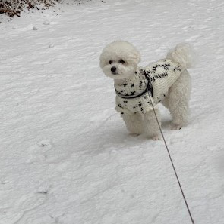

In [22]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './figures/leo5.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img

In [23]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
print(x.shape)

x = preprocess_input(x) # Imagenet data 전처리를 위한 method. 이미지의 centering/scaling

(1, 224, 224, 3)


- 입력 이미지가 어느 클래스로 분류되는지 확인

In [24]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02113624', 'toy_poodle', 0.26936725), ('n02113799', 'standard_poodle', 0.14050546), ('n02111889', 'Samoyed', 0.11156442)]


- 분류되는 클래스의 index를 저장. 즉 toy_poodle에 해당되는 클래스 번호를 `idx`에 저장

In [26]:
idx=np.argmax(preds[0])
idx

265

#### Grad-CAM 알고리즘 설정

In [27]:
class_output = model.output[:, idx]
last_conv_layer = model.get_layer('block5_conv3') # vgg16의 마지막 conv layer의 feature map을 추출

- 마지막 conv layer의 출력은 14*14 크기의 feature map이 512개 있는 형태

In [28]:
last_conv_layer.output_shape 

(None, 14, 14, 512)

In [29]:
# toy_poodle 클래스를 `block5_conv3`의 feature map output으로 미분한 gradient를 저장 
# (none, 14, 14, 512)
grads = K.gradients(class_output, last_conv_layer.output)[0]  
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 각 feature map 별로 gradient 값을 평균. 각 feature map에 대한 가중치로 사용하기 위해 저장. (512, )

In [30]:
# 입력 이미지를 넣었을 때 위에서 계산한 pooled_grads와 block5_conv3의 output이 출력되는 함수 생성 
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x]) # 위의 함수에 leo 이미지를 입력하여 두개의 출력값을 저장

# conv_layer_output_value에 저장된 512개의 feature map에 pooled_grads_value에 저장된 가중치를 곱해줌
# toy_poodle 클래스에서 각 채널이 얼마나 중요한지에 대한 가중치를 반영
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 512개 채널에 대해 평균
heatmap = np.mean(conv_layer_output_value, axis=-1)

#### 히트맵으로 시각화

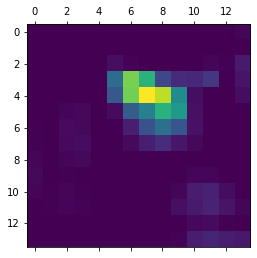

In [31]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

#### 원본 이미지에 히트맵을 함께 그리기 

In [32]:
!pip install opencv-python-headless

In [33]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./class_act.jpg', superimposed_img)

True


References
- [Deep Learning with Python, François Chollet,](https://www.manning.com/books/deep-learning-with-python)